┌ Info: Found initial step size
└   ϵ = 0.003125
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (5000×15×1 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 2.51 seconds
Compute duration  = 2.51 seconds
parameters        = β_strength, β_home, α
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

  β_strength   -0.1391    0.0166    0.0018    94.5121   138.4969    1.0023     ⋯
      β_home    0.4915    0.0021    0.0002    84.3727   147.1322    1.0004     ⋯
           α    1.0961    0.0099    0.0030    11.9604    18.3821    1.3093     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0

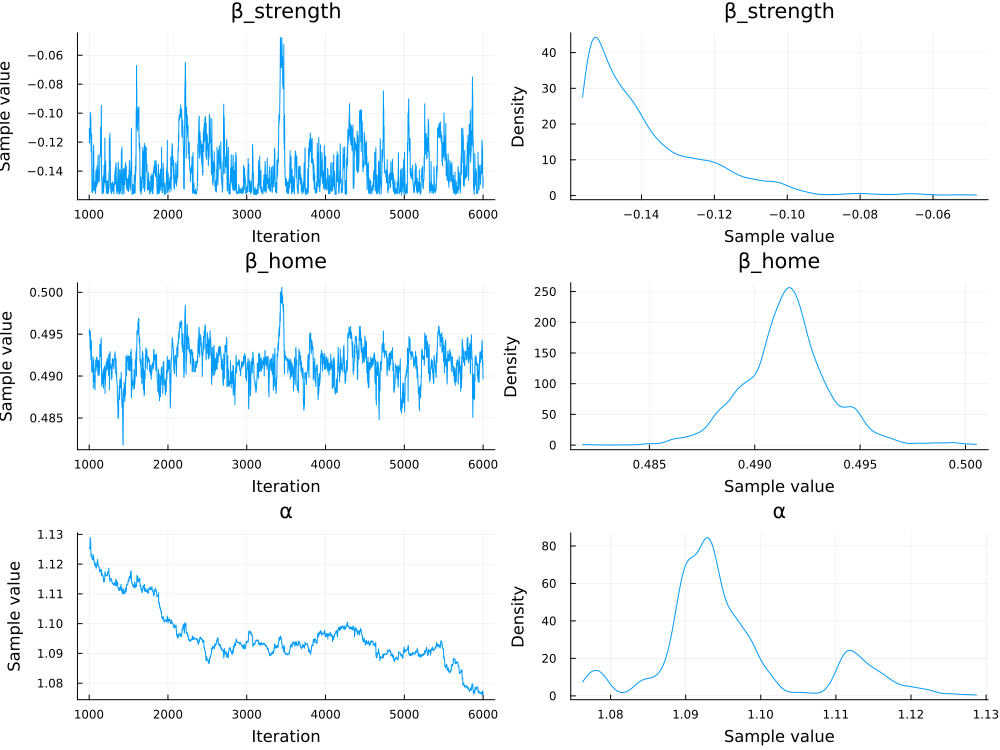

Probability of win: 0.3937929141788092


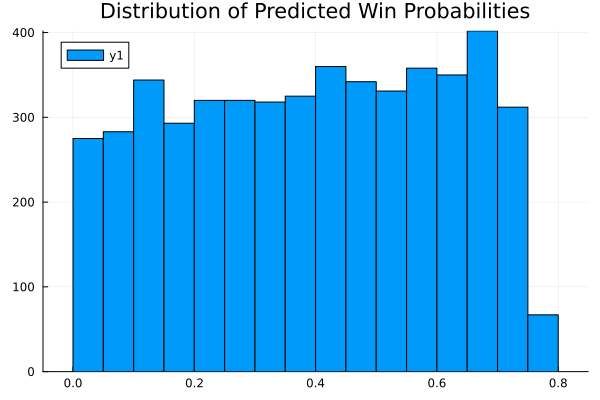

In [6]:
using Turing
using Distributions
using DataFrames
using Random
using StatsPlots # For plotting the chains

# ... (data generation code from previous response)

# Turing model (same as before)
@model function betting_model(team_strength, home_advantage, odds, win)
    # Priors
    β_strength ~ Normal(0, 1) # Effect of team strength
    β_home ~ Normal(0, 1) # Effect of home advantage
    α ~ truncated(Pareto(1, 1), lower = 1.0) #Shape parameter for the pareto distribution

    # Likelihood
    for i in 1:length(win)
        # Model for base odds (before Pareto)
        base_odds = exp(β_strength * team_strength[i] + β_home * home_advantage[i])
        odds[i] ~ Pareto(α, base_odds)

        # Model for win probability (using the simulated odds)
        win_prob = 1 / odds[i]
        win[i] ~ Bernoulli(win_prob)
    end
    return β_strength, β_home, α
end

# Create and sample the model
model = betting_model(df.TeamStrength, df.HomeAdvantage, df.Odds, df.Win)
chain = sample(model, NUTS(0.65), 5000) # Increased samples for better convergence

display(chain)

display(plot(chain)) # Plots the chains to assess convergence
# savefig("chains.png")

# Prediction using generated quantities
function predict_win_probability(chain, new_team_strength, new_home_advantage)
    n_samples = length(chain)
    win_probs = zeros(n_samples)
    for i in 1:n_samples
        β_strength_i = chain[:β_strength][i]
        β_home_i = chain[:β_home][i]
        α_i = chain[:α][i]

        base_odds = exp(β_strength_i * new_team_strength + β_home_i * new_home_advantage)
        odds_new = rand(Pareto(α_i, base_odds))
        win_probs[i] = 1 / odds_new
    end
    return win_probs
end

new_team_strength = 1.5
new_home_advantage = 1
win_probabilities = predict_win_probability(chain, new_team_strength, new_home_advantage)
println("Probability of win: ", mean(win_probabilities))
display(histogram(win_probabilities, title="Distribution of Predicted Win Probabilities"))
# savefig("win_probs_hist.png")